In [18]:
from most_active_cell import MOST_ACTIVE_CELL as most_active_cell

import seaborn as sns
from matplotlib import pyplot as plt
from bokeh.models import ColumnDataSource
from bokeh.plotting import gmap, output_notebook, figure, show, output_file
import pandas as pd

In [19]:
def get_count(cell, start_or_end):
    return pd.read_parquet('../data/drivenow/grid_%s.parquet' % start_or_end)\
        [lambda df: df.cell == cell]\
        .groupby(['timestep'])\
        .size()\
        .rename('trip_%s' % start_or_end)

In [20]:
get_count(cell=most_active_cell, start_or_end='start')

timestep
2016-01-01 00:00:00     5
2016-01-01 01:00:00     5
2016-01-01 02:00:00     9
2016-01-01 03:00:00     4
2016-01-01 04:00:00     5
                       ..
2019-12-31 19:00:00    17
2019-12-31 20:00:00     6
2019-12-31 21:00:00     3
2019-12-31 22:00:00    10
2019-12-31 23:00:00     2
Name: trip_start, Length: 31064, dtype: int64

In [21]:
def get_prev_step(cell, start_or_end):
    df = get_count(cell=cell, start_or_end=start_or_end)
    df_prev = df\
        .reset_index()\
        .assign(timestep=lambda df: df.timestep + pd.Timedelta('1h'))\
        .set_index('timestep')\
        .rename(columns={'trip_%s' % start_or_end: 'trip_%s_previous_timestep' % start_or_end})
    return pd.merge(
        how='inner',
        left=df,
        right=df_prev,
        left_index=True,
        right_index=True
    ).drop(columns=['trip_%s' % start_or_end])

get_prev_step(cell=most_active_cell, start_or_end='start')

,trip_start_previous_timestep
timestep,
2016-01-01 01:00:00,5
2016-01-01 02:00:00,5
2016-01-01 03:00:00,9
2016-01-01 04:00:00,4
2016-01-01 05:00:00,5
...,...
2019-12-31 19:00:00,13
2019-12-31 20:00:00,17
2019-12-31 21:00:00,6


In [22]:
def get_supply(cell):
    df_end = get_count(cell, 'end')
    df_end_prev_step = get_prev_step(cell, 'end')
    df_start_prev_step = get_prev_step(cell, 'start')
    return pd.merge(
        how='inner',
        left=pd.merge(how='inner', left=df_end, right=df_end_prev_step, left_index=True, right_index=True),
        right=df_start_prev_step,
        left_index=True, right_index=True
    )\
    .assign(supply=lambda df: df.trip_end + \
            (df.trip_end_previous_timestep  - df.trip_start_previous_timestep).clip(lower=0))\
    .supply\
    .sort_index()

get_supply(cell=most_active_cell)

timestep
2016-01-01 02:00:00     1
2016-01-01 03:00:00     5
2016-01-01 04:00:00     3
2016-01-01 09:00:00     1
2016-01-01 14:00:00     5
                       ..
2019-12-31 19:00:00    32
2019-12-31 20:00:00    12
2019-12-31 21:00:00    15
2019-12-31 22:00:00    14
2019-12-31 23:00:00    17
Name: supply, Length: 26225, dtype: int64

In [23]:
def get_demand_and_supply(cell):
    return pd.merge(
        how='inner',
        left=get_count(cell=cell, start_or_end='start').rename('demand'),
        right=get_supply(cell=cell),
        left_index=True,
        right_index=True)

get_demand_and_supply(cell=most_active_cell)

,demand,supply
timestep,,
2016-01-01 02:00:00,9,1
2016-01-01 03:00:00,4,5
2016-01-01 04:00:00,5,3
2016-01-01 09:00:00,3,1
2016-01-01 14:00:00,5,5
...,...,...
2019-12-31 19:00:00,17,32
2019-12-31 20:00:00,6,12
2019-12-31 21:00:00,3,15


In [24]:
get_demand_and_supply(cell=most_active_cell)\
    .reset_index()\
    [lambda df: df.demand > df.supply]\
    [lambda df: df.timestep.dt.year > 2016]

,timestep,demand,supply
5444,2017-01-01 01:00:00,4,1
5453,2017-01-01 19:00:00,4,2
5457,2017-01-02 11:00:00,10,7
5460,2017-01-02 14:00:00,11,3
5461,2017-01-02 15:00:00,7,5
...,...,...,...
26201,2019-12-30 22:00:00,12,10
26208,2019-12-31 07:00:00,2,1
26214,2019-12-31 13:00:00,23,18
26215,2019-12-31 14:00:00,21,19


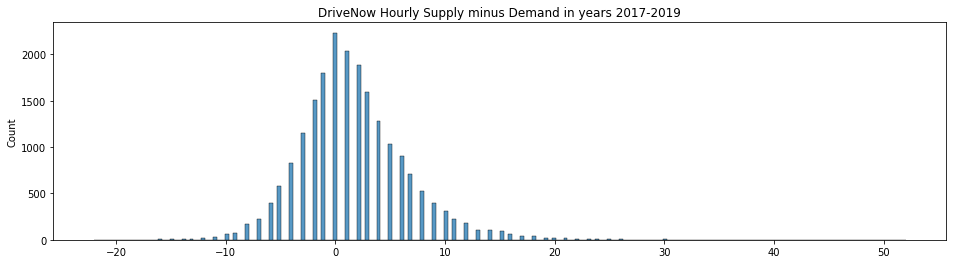

In [35]:
def distribution_if_supply_minus_demand():
    df = get_demand_and_supply(cell=most_active_cell)\
        .reset_index()\
        [lambda d: d.timestep.dt.year > 2016]
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.set_title('DriveNow Hourly Supply minus Demand in years 2017-2019')
    sns.histplot(df.supply - df.demand, ax=ax)


distribution_if_supply_minus_demand()

In [12]:
def plot_time_series(df):
    output_notebook()
    p = figure(x_axis_type="datetime", plot_width=900, plot_height=250)
    p.scatter('timestep', 'supply', source=ColumnDataSource(pd.DataFrame(df)), color='red')
    p.scatter('timestep', 'demand', source=ColumnDataSource(pd.DataFrame(df)), color='blue')
    return show(p)

plot_time_series(pd.merge(
    how='inner',
    left=get_count(cell=most_active_cell, start_or_end='start').rename('demand'),
    right=get_supply(cell=most_active_cell),
    left_index=True,
    right_index=True)
)

Loading BokehJS ...

# Conclusion
As for GreenMobility, supply can fall below demand, despite having information about fleet rebalancing ("ghost trips").